# chain the previous scrips together here

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import h3
from util.speed import *
from util.group import *
# Set up constants
FPS = 29.97002997002997
DATA_FOLDER = "_data"

In [2]:
# these are known feature of the video
videoname = '20081008-141944b08'
video_group = videoname[:-3]
video_start_at = pd.to_datetime("2008-10-08T15:24:16")
video_start_frame = 0
loc_name = "bryant_park"

traceGDF = load_video(videoname, video_start_at, video_group,destfolder = DATA_FOLDER, video_start_frame = video_start_frame)
traceGDF = get_speed_vector(traceGDF, n = 0.5)
traceGDF['video_location'] = loc_name
traceGDF['second_from_start'] = traceGDF['timestamp'].apply(lambda x: x.hour*3600 + x.minute*60 + x.second)
traceGDF['hex_id'] = traceGDF.apply(lambda x: h3.geo_to_h3(x['lat'], x['lon'], 15), axis = 1)
traceGDF.to_csv(os.path.join(DATA_FOLDER, "stage1_trace.csv"), index = False)

groupGDF = generate_group_final(traceGDF)
groupGDF.to_csv(os.path.join(DATA_FOLDER, "stage2_group.csv"), index = False)

# Test Visualization

<AxesSubplot:>

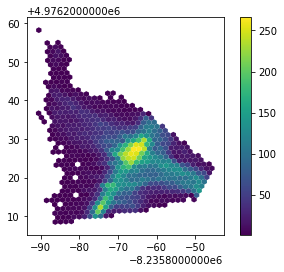

In [22]:
# visualzie the heatmap on the ground
hex_summary = traceGDF.groupby('hex_id')['track_id'].nunique().reset_index()
hex_summary.columns = ['hex_id', 'n_people']
from shapely.geometry import Polygon
# plot the hexagon map using geojson using geopandas
hex_summary['geometry'] = hex_summary['hex_id'].apply(lambda x: Polygon(h3.h3_to_geo_boundary(x, geo_json = True)))
hex_summary = gpd.GeoDataFrame(hex_summary, crs = "EPSG:4326")
hex_summary = hex_summary.to_crs("EPSG:3857")
hex_summary.plot(column = 'n_people', legend = True)